# -------------------------------------------------------------------------
#  Stream Temperature - Compare RBM-res output and USGS measured 
## Summer 2016
## Ryan Niemeyer, UW Hydro
# -------------------------------------------------------------------------

In [ ]:
# To Do: 
#    A) fix the mean between max and min (it still calculates, but can use .mean for pandas)
#    B) (make sure it worked) creating "NaN"s correctly? (I think now they are just strings)
#    C)  add the root-meansquare difference (RMSD), and absolute mean bias difference (AMBD), and relative mean bias difference

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import datetime as dt
import os
from os import listdir
from os.path import isfile, join
import re
import datetime
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
import matplotlib

from os import listdir
from os.path import isfile, join

%matplotlib inline

In [6]:
matplotlib.style.use('ggplot')

# -------------------------------------------------------------------------
##                                           Read in data 
# -------------------------------------------------------------------------

In [7]:
path_files = '/raid3/rniemeyr/RBM/data/USGS/Tennessee_Basin'
usgs_files = [f for f in listdir(path_files) if isfile(join(path_files, f))]

# removing sites that the grid is not in .spat file: 03601630.txt, 
usgs_files = usgs_files[0:16] + usgs_files[17:len(usgs_files)]

In [8]:
print(usgs_files)

['0351706800.txt', '03497300.txt', '03604000.txt', '03584600.txt', '03582000.txt', '03544970.txt', '03501500.txt', '03512000.txt', '03456991.txt', '03460000.txt', '03451500.txt', '03446000.txt', '03524000.txt', '03524500.txt', '03524740.txt', '03490000.txt', '03597860.txt', '03598000.txt', '03598165.txt', '0359816545.txt', '03598177.txt', '03598173.txt', '03571850.txt', '03603000.txt', '03604500.txt', '03592825.txt', '03592800.txt', '03584500.txt', '03571000.txt', '03560110.txt', '03558000.txt', '03519500.txt', '03460795.txt', '03532000.txt', '03531500.txt', '03529500.txt', '03527000.txt', '03526990.txt', '03524550.txt', '03526000.txt', '03488450.txt', '03488500.txt', '03488445.txt', '03473000.txt', '03475000.txt', '03495500.txt']


In [9]:
print(usgs_files[45:46])

['03495500.txt']


In [10]:
# ------------------ information for reservoirs --------------------
path_temp = '/raid3/rniemeyr/RBM/two_layer_model/RBM_Yixin/RIPS/model_run/source/VIC_RBM/RBM_processing/output/list,USGS_temperature_gauges.txt'
list_usgs = pd.read_table(path_temp,  sep=',', header='infer')
list_usgs = pd.DataFrame(list_usgs)
#list_usgs = list_usgs.drop('Unnamed: 9', axis=1)
#list_usgs.rename(columns={'draiange area(mi^2)':'drainage_area_sq_miles'}, inplace=True)  # rename drainage column name

In [11]:
list_usgs.columns 

Index(['USGS_number', 'Name', 'river', 'drainage_area_sq_mi', 'start', 'end',
       'years', 'lat', 'lon'],
      dtype='object')

In [12]:
lat_grid = pd.DataFrame(np.around(8.0*(list_usgs.lat)-0.5)/8.0 + 0.0625)
list_usgs['lat_grid'] = pd.Series(lat_grid.lat, index=list_usgs.index)

lon_grid = pd.DataFrame(np.around(8.0*(list_usgs.lon)-0.5)/8.0 + 0.0625)
list_usgs['lon_grid'] = pd.Series(lon_grid.lon, index=list_usgs.index)

In [13]:
#=======================================================
# Parameter setting for RBM-res
#=======================================================

#=== input ===#
# We assume that direct RBM output files are: $rbm_output_dir/$run_code.Temp/.Spat
# A directory named $rbm_run_code will be made under the RBM output directory; formatted files will be under this directory
run_code = 'Tennessee20160531' # 'Tennessee_1949_2010'
rbm_output_dir = '/raid/yifan/RBM/Tennessee/output'  # '/raid2/ymao/VIC_RBM_east/VIC_RBM/model_run/output/RBM/Maurer_8th/Tennessee/Tennessee_1949_2010'  # RBM output directory
rbm_output_dir2 = '/raid3/rniemeyr/RBM/two_layer_model/RBM_Yixin/RIPS/model_run/source/VIC_RBM/RBM_processing/output'
nseg_nday_filename = 'Tennessee.nseg_nday'  # run_code + '.nseg_nday'  # a text file; first line: total # all stream segments; second line: total # days of the run

temp = rbm_output_dir + '/' + run_code + '.Temp'  # .Temp file
spat = rbm_output_dir + '/' + run_code + '.Spat'  # .Spat file
nseg_nday_path = os.path.join(rbm_output_dir2, nseg_nday_filename)  # run_code + '.nseg_nday'  # a text file; first line: total # all stream segments; second line: tot
nseg_nday = np.loadtxt(nseg_nday_path)
nseg = int(nseg_nday[0])  # total number of all segments
nday = int(nseg_nday[1])  # total number of days


In [70]:
#=======================================================
# Parameter setting - RBM w/simple reservoir
#=======================================================

#=== input ===#
# We assume that direct RBM output files are: $rbm_output_dir/$run_code.Temp/.Spat
# A directory named $rbm_run_code will be made under the RBM output directory; formatted files will be under this directory
run_code = 'Tennessee' # 'Tennessee_1949_2010'
rbm_output_dir = '/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/RBM/Maurer_8th/Tennessee/hist_1949_2010.from_RVIC.calibrated_1961_1970.Mohs_v1.Leop_v1.reservoir'
rbm_output_dir2= '/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/RBM/Maurer_8th/Tennessee/hist_1949_2010.from_RVIC.calibrated_1961_1970.Mohs_v1.Leop_v1.reservoir'
nseg_nday_filename = 'Tennessee.nseg_nday'  # run_code + '.nseg_nday'  # a text file; first line: total # all stream segments; second line: total # days of the run

temp = rbm_output_dir + '/' + run_code + '.Temp'  # .Temp file
spat = rbm_output_dir + '/' + run_code + '.Spat'  # .Spat file
nseg_nday_path = os.path.join(rbm_output_dir2, nseg_nday_filename)  # run_code + '.nseg_nday'  # a text file; first line: total # all stream segments; second line: tot
nseg_nday = np.loadtxt(nseg_nday_path)
nseg = int(nseg_nday[0])  # total number of all segments
nday = int(nseg_nday[1])  # total number of days

# ------------------------------------------------------------------------------------------
##                                           Functions 
# ------------------------------------------------------------------------------------------

In [14]:
# ---------------- functions to read in RBM data -----------------

def read_config(config_file, default_config=None):
    """
    Return a dictionary with subdictionaries of all configFile options/values
    """

    from netCDF4 import Dataset
    try:
        from cyordereddict import OrderedDict
    except:
        from collections import OrderedDict
    try:
        from configparser import SafeConfigParser
    except:
        from ConfigParser import SafeConfigParser
    import configobj

    config = SafeConfigParser()
    config.optionxform = str
    config.read(config_file)
    sections = config.sections()
    dict1 = OrderedDict()
    for section in sections:
        options = config.options(section)
        dict2 = OrderedDict()
        for option in options:
            dict2[option] = config_type(config.get(section, option))
        dict1[section] = dict2

    if default_config is not None:
        for name, section in dict1.items():
            if name in default_config.keys():
                for option, key in default_config[name].items():
                    if option not in section.keys():
                        dict1[name][option] = key

    return dict1




def config_type(value):
    """
    Parse the type of the configuration file option.
    First see the value is a bool, then try float, finally return a string.
    """
    val_list = [x.strip() for x in value.split(',')]
    if len(val_list) == 1:
        value = val_list[0]
        if value in ['true', 'True', 'TRUE', 'T']:
            return True
        elif value in ['false', 'False', 'FALSE', 'F']:
            return False
        elif value in ['none', 'None', 'NONE', '']:
            return None
        else:
            try:
                return int(value)
            except:
                pass
            try:
                return float(value)
            except:
                return value
    else:
        try:
            return list(map(int, val_list))
        except:
            pass
        try:
            return list(map(float, val_list))
        except:
            return val_list

In [15]:
# ------------ NAN filter AND Nash-Sutcliffe Model Efficiency ---------

def filter_nan(s,o):
    """
    this functions removed the data  from simulated and observed data
    whereever the observed data contains nan
    
    this is used by all other functions, otherwise they will produce nan as 
    output
    """
    data = np.array([s.flatten(),o.flatten()])
    data = np.transpose(data)
    data = data[~np.isnan(data).any(1)]
    return data[:,0],data[:,1]

def NS(s,o):
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    # s,o = filter_nan(s,o)
    return 1 - sum((s-o)**2)/sum((o-np.mean(o))**2)

In [51]:
# ----- root-meansquare difference (RMSD), and absolute mean bias difference (AMBD) ----------


def RMSD(s,o):
    """
    Root-mean square difference (RMSD)
    input:
        s: simulated
        o: observed
    output:
        rmsd: Root-mean square difference
    """
    # s,o = filter_nan(s,o)
    # return (1/len(s)) * (sqrt(sum((s-o)**2)))  # what i originally used
    return  sqrt(sum((s-o)**2)/(len(s)))

def normRMSD(s,o):
    """
    Normalized Root-mean square difference (RMSD)
    input:
        s: simulated
        o: observed
    output:
        normRMSD: Normalized root-mean square difference
    """
    # s,o = filter_nan(s,o)
    # return (1/len(s)) * ((sqrt(sum((s-o)**2)))/ (np.median(o) ) )
    return  (sqrt(sum((s-o)**2)/(len(s)))) / (np.median(o) )

#def AMBD(s,o):   # original normalized bias
    """
    Absolute mean bias difference (RMSD)
    input:
        s: simulated
        o: observed
    output:
        rmsd: Root-mean square difference
    """
    # s,o = filter_nan(s,o)
#    return (1/len(s)) * (sum(s-o))

def AMBD(s,o):
    """
    normalized bias
    input:
        s: simulated
        o: observed
    output:
        norm_bias: normalized bias
    """
    # s,o = filter_nan(s,o)
    return (np.mean(s) - np.mean(o))/np.median(o)

def bias(s,o):
    """
    bias
    input:
        s: simulated
        o: observed
    output:
        bias
    """
    # s,o = filter_nan(s,o)
    return np.mean(s) - np.mean(o)

In [50]:
# Test out tests
s = np.array([1,1,1,1,1,1])
o = np.array([2,3,2,3,2,3])

print(RMSD(s,o) )
print(normRMSD(s,o))

1.58113883008
0.632455532034


In [23]:
    #=========================================================
    #
    #   Nash-Sutcliffe Model Efficiency (NS),
    #   Root-mean square difference (RMSD),
    #   Normalized Root-mean square difference (normRMSD), and
    #   Absolute mean bias difference (AMBD)
    #
    #=========================================================
 
    #=========================================================
    #   Annual
    #=========================================================

    # ======================= Temperature ========================
    
    rbm_df = pd.DataFrame({ 'rbm':data_rbm2.T_stream ,'obs':data_usgs2.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t = "%.3f" % ns_val_t
        ns_val_t = float(ns_val_t)
        
        rmsd_val_t = RMSD(rbm_df.rbm, rbm_df.obs)
        rmsd_val_t = "%.3f" % rmsd_val_t
        rmsd_val_t = float(rmsd_val_t)
        
        nrmsd_val_t = normRMSD(rbm_df.rbm, rbm_df.obs)
        nrmsd_val_t = "%.3f" % nrmsd_val_t
        nrmsd_val_t = float(nrmsd_val_t)
        
        ambd_val_t = AMBD(rbm_df.rbm, rbm_df.obs)
        ambd_val_t = "%.3f" % ambd_val_t
        ambd_val_t = float(ambd_val_t)
       
    else:
        ns_val_t = None
        rmsd_val_t = None
        nrmsd_val_t = None
        ambd_val_t = None
        
    ns_val_t_days = len(rbm_df)
    
    # ======================= Flow ========================
    
    rbm_df = pd.DataFrame({ 'rbm':data_rbm2.flow ,'obs':data_usgs2.flow_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_f = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_f = "%.3f" % ns_val_f
        ns_val_f = float(ns_val_f)
        
        rmsd_val_f = RMSD(rbm_df.rbm, rbm_df.obs)
        rmsd_val_f = "%.3f" % rmsd_val_f
        rmsd_val_t = float(rmsd_val_f)
        
        nrmsd_val_f = normRMSD(rbm_df.rbm, rbm_df.obs)
        nrmsd_val_f = "%.3f" % nrmsd_val_f
        nrmsd_val_f = float(nrmsd_val_f)
        
        ambd_val_f = AMBD(rbm_df.rbm, rbm_df.obs)
        ambd_val_f = "%.3f" % ambd_val_f
        ambd_val_f = float(ambd_val_f)
        
    else:
        ns_val_f = None
        rmsd_val_f = None
        nrmsd_val_f = None
        ambd_val_f = None
        
    ns_val_f_days = len(rbm_df)
    


In [173]:
usgs_files = usgs_files[13:14]  # file with min and max (no mean) - 03524500.txt

In [169]:
usgs_files = usgs_files[21:22]  # smallest file - 03598177.txt

In [208]:
usgs_files = usgs_files[0:1]
usgs_files = usgs_files[2:3]  # smallest file - 03598177.txt
usgs_files = usgs_files[16:17]  #    03601630.txt -  35.8125,-87.0625 - not a grid cell NOTE the grid cell doesn't exist (may need to choose nearest or something)
usgs_files = usgs_files[20:21]  #  03598177.txt - smallest files
usgs_files = usgs_files[24:25]  #    03604500 - has min and max temperature (no mean)
usgs_files = usgs_files[32:33]  #  03460795.txt - larger file with flow and temp
usgs_files = usgs_files[45:46]  #  03495500.txt - Holston River near Knoxvillie

In [143]:
usgs_files = usgs_files[45:46]  #  03495500.txt - Holston River near Knoxvillie

In [40]:
usgs_files = usgs_files[25:len(usgs_files)]  

In [7]:
usgs_files = usgs_files[35:36] # cell that last messed up (June.13): 03529500.txt

In [52]:
print(usgs_files)

['0351706800.txt', '03497300.txt', '03604000.txt', '03584600.txt', '03582000.txt', '03544970.txt', '03501500.txt', '03512000.txt', '03456991.txt', '03460000.txt', '03451500.txt', '03446000.txt', '03524000.txt', '03524500.txt', '03524740.txt', '03490000.txt', '03597860.txt', '03598000.txt', '03598165.txt', '0359816545.txt', '03598177.txt', '03598173.txt', '03571850.txt', '03603000.txt', '03604500.txt', '03592825.txt', '03592800.txt', '03584500.txt', '03571000.txt', '03560110.txt', '03558000.txt', '03519500.txt', '03460795.txt', '03532000.txt', '03531500.txt', '03529500.txt', '03527000.txt', '03526990.txt', '03524550.txt', '03526000.txt', '03488450.txt', '03488500.txt', '03488445.txt', '03473000.txt', '03475000.txt', '03495500.txt']


In [83]:
data_summary.head()

,usgs_number,drainage_area_sq_mi,start_yr,end_yr,tot_days,lat,lon,lat_grid,lon_grid,nash_sutclf_temp,...,nash_sutclf_ond_flow,nash_sutclf_ond_f_days,rmsd_temp,nrmsd_temp,ambd_temp,bias_temp,rmsd_flow,nrmsd_flow,ambd_flow,bias_flow
0,3.51707e+08,206,1999,2016,6047,35.4385,-83.9193,35.4375,-83.9375,0.396,...,-0.61,1104,5.523,0.378,0.211,3.084,418.603,4.55,-0.278,-25.534
0,3.4973e+06,106,1976,2016,3003,35.6645,-83.711,35.6875,-83.6875,-0.061,...,-0.671,3312,6.602,0.555,0.363,4.316,405.224,2.1,-0.71,-137.04
0,3.604e+06,447,1964,2016,1439,35.4966,-87.8337,35.4375,-87.8125,0.921,...,-0.151,4416,2.321,0.172,-0.084,-1.135,1772.04,3.903,-1.462,-663.849
0,3584600,1805,2014,2016,564,35.0137,-86.9949,35.0625,-86.9375,None,...,None,0,None,None,None,None,None,None,None,None
0,3582000,827,2012,2016,1313,35.1345,-86.5395,35.1875,-86.5625,None,...,None,0,None,None,None,None,None,None,None,None


In [84]:
data_summaryx.head()

,usgs_number,drainage_area_sq_mi,start_yr,end_yr,tot_days,lat,lon,lat_grid,lon_grid,nash_sutclf_temp,...,nash_sutclf_ond_flow,nash_sutclf_ond_f_days,rmsd_temp,nrmsd_temp,ambd_temp,bias_temp,rmsd_flow,nrmsd_flow,ambd_flow,bias_flow
0,3.51707e+08,206,1999,2016,6047,35.4385,-83.9193,35.4375,-83.9375,0.396,...,-0.61,1104,5.523,0.378,0.211,3.084,418.603,4.55,-0.278,-25.534
0,3.4973e+06,106,1976,2016,3003,35.6645,-83.711,35.6875,-83.6875,-0.063,...,-0.671,3312,6.609,0.555,0.363,4.32,405.224,2.1,-0.71,-137.04
0,3.604e+06,447,1964,2016,1439,35.4966,-87.8337,35.4375,-87.8125,0.921,...,-0.151,4416,2.321,0.172,-0.084,-1.135,1772.04,3.903,-1.462,-663.849
0,3584600,1805,2014,2016,564,35.0137,-86.9949,35.0625,-86.9375,None,...,None,0,None,None,None,None,None,None,None,None
0,3582000,827,2012,2016,1313,35.1345,-86.5395,35.1875,-86.5625,None,...,None,0,None,None,None,None,None,None,None,None


In [68]:
data_summaryx = data_summary

In [71]:
# =================================================================================================
#
#       Loop to compare Nash-Sutclifee Values between RBM-res and USGS data
#
# =================================================================================================    

data_summary = pd.DataFrame()

for file in usgs_files:
    filePath = path_files + '/' + file
    # file2 = open( filePath, 'r' )

#=================================================================================================
#                         read in USGS data
#=================================================================================================    
    with open(filePath,  'r') as f:
        line_count = 0
        for line in f:
            line_count = line_count + 1
            if line[0:1] != '#':
                if line[0:1] =='a':
                    headers = line.split('\t')
                    headers[len(headers)-1] = headers[len(headers)-1].rstrip('\n')  #strip \n
                    line_count_f = line_count
                    #row_start = row_start.append()
                    break
                #break
            #break
    f.close()
    print(file)
    data_usgs = pd.read_table(filePath, skiprows=line_count + 1, sep='\t', 
    names = headers) # index_col='datetime'

    # ======================= read in temperature ====================
    mean_pres = [i for i, s in enumerate(headers) if '00010_00003' in s] # mean temperature
    max_pres = [i for i, s in enumerate(headers) if '00010_00001' in s] # max temperature
    min_pres = [i for i, s in enumerate(headers) if '00010_00002' in s] # min temperature
    instant_pres = [i for i, s in enumerate(headers) if '00010_00011' in s] # min temperature
    if len(mean_pres) > 0:
        print('mean temp')
        indices = mean_pres
        indices2 = [i for i, s in enumerate(headers) if 'datetime' in s]
        indices = indices + indices2
        indices = sorted(list(set(indices)))    
        data_usgs2 = data_usgs[indices]
        data_usgs2.columns = ['datetime','t_mean','t_cd']

    elif len(max_pres) > 0 and len(min_pres) > 0:
        print('max/min temp')
        indices = max_pres
        indicesb = min_pres
        indices = sorted(indices + indicesb)
        indices2 = [i for i, s in enumerate(headers) if 'datetime' in s]
        indices = indices + indices2
        indices = sorted(list(set(indices)))    
        data_usgs2 = data_usgs[indices]
        data_usgs2.columns = ['datetime','t_max','tmax_cd','t_min','tmin_cd']
        data_usgs2['t_mean'] = data_usgs2[['t_max','t_min']].mean(axis=1)
        # data_usgs2['t_mean'] = (data_usgs2['t_max'] + data_usgs2['t_min']) /2
        
    elif len(instant_pres) > 0 :
        print('instantaneous temperature')
        indices = instant_pres
        indices2 = [i for i, s in enumerate(headers) if 'datetime' in s]
        indices = indices + indices2
        indices = sorted(list(set(indices)))    
        data_usgs2 = data_usgs[indices]
        data_usgs2.columns = ['datetime','t_mean','tmean_cd']
        
    if len(data_usgs2) > 0:
        datetime2 = pd.to_datetime(data_usgs2.datetime)
        data_usgs2 = data_usgs2.set_index(datetime2)
    else:
        print('no measured (USGS) data present at this site')
        data_usgs2 = None
        
    # ======================= read in flow ====================
    mean_flow_pres = [i for i, s in enumerate(headers) if '00060_00003' in s] # mean temperature
    if len(mean_flow_pres) > 0:
        print('mean flow')
        indices = mean_flow_pres
        indices2 = [i for i, s in enumerate(headers) if 'datetime' in s]
        indices = indices + indices2
        indices = sorted(list(set(indices)))    
        data_usgs2b = data_usgs[indices]
        data_usgs2b.columns = ['datetime','flow_mean','flow_cd']
        data_usgs2b = data_usgs2b.set_index(datetime2)
        data_usgs2['flow_mean'] = data_usgs2b['flow_mean'] 

#=================================================================================================
#                         read in RBM data
#=================================================================================================

    # ---------------- match up reservoir to it's info -------------
    resx = file.split('.')
    index_res =[i for i,x in enumerate(list_usgs.USGS_number) if x == int(resx[0])]

    #=========================================================
    # Extracting grid cell data
    #=========================================================

    #=== identify which lines in .Spat are corresponding to the target grid cell ===#
    f = open(spat, 'r')
    line_count = 0
    cell_info = {}  # a dictionary; keys are line numbers of the target grid cell (int); element isa list with 2 elements: [reach_ind, seg_ind]

    while 1:  # loop over each line in the .Spat file
        line = f.readline().rstrip("\n")
        line_count = line_count + 1  # current line number
        x2 = [int(s) for s in line.split() if s.isdigit()]  # strips space so only have numbers\
        ncell = float(line.split()[12])

        if line=="":
            break
        lat = float(line.split()[4])
        lon = float(line.split()[5])
        if all((lat==list_usgs.lat_grid[index_res]) & (lon==list_usgs.lon_grid[index_res])):  # if this line corresponds to the target grid cell
            reach_ind = int(line.split()[0])  # reach index, defined by RBM
            seg_ind = int(line.split()[6])  # seg index within a node, 1 or 2
            dict = {}  # create a new element in the dictionary
            cell_info[line_count] = [reach_ind, seg_ind]
    f.close()

    # ============== use cell for largest reach in cell =========
    # if cell is conflict, one cell has multiple reaches 
    cell_info = max(cell_info[max(list(cell_info.keys()))])
    cell_info = [cell_info, 1000000]   # I added 1000000 because got an error message about cell_info not iterable
    
    #=========================================================
    #   read in all the temperature
    #=========================================================
    
    #=== read .Temp file and extract target grid cells ===#
    f = open(temp, 'r')
    line_count = 0
    data_rbm = []   # final data to write; this is a dictionary whose keys are line numbers in the .Spat file (each key is one stream seg), and dicrionary content is corresponding data (np array, [year] [month] [day] [flow(cfs) [T_stream(degC)]]);
    #for i in cell_info:
    #    data_rbm[i] = []
    while 1:  # loop over each line in the .Temp file
        line = f.readline().rstrip("\n")
        line_count = line_count + 1
        if line=="":
            break
        line_num_in_spat = line_count%nseg  # corresponding line number in the .Spat file

        if line_num_in_spat in cell_info:  # if the current line in the .Temp file is corresponding to the target grid cell, save this line
            decimal_year = line.split()[0]
            year = int(decimal_year.split('.')[0])
            day_of_year = int(line.split()[1])
            if day_of_year > 360 and float('0.'+decimal_year.split('.')[1]) <= 0.005:  # correct bad decimal year integer part
                year = year - 1
            date = dt.datetime(year, 1, 1) + dt.timedelta(days=day_of_year-1)  # convert day of year to date
            flow = float(line.split()[8])
            T_stream = float(line.split()[5])
            T_headwater = float(line.split()[6])
            T_air = float(line.split()[7])
            cellx = float(line.split()[2])
            data_rbm.append([year, date.month, date.day, flow, T_stream, T_headwater, T_air, cellx])
            # data_rbm[line_num_in_spat].append([year, date.month, date.day, flow, T_stream, T_headwater, T_air])
            
    #        print 'Processing', year, date.month, date.day, '...'

            if line_num_in_spat==1928:
                print(line_num_in_spat, data_rbm[line_num_in_spat])
                exit()
            

    data_rbm2 = pd.DataFrame(data_rbm)
    data_rbm2.columns = ['year', 'month', 'day', 'flow', 'T_stream', 'T_headw', 'T_air', 'cell']
    data_rbm2['datetime'] = pd.to_datetime(data_rbm2.year*10000+data_rbm2.month*100+data_rbm2.day,format='%Y%m%d')
    datetime2 = pd.to_datetime(data_rbm2.datetime)
    data_rbm2 = data_rbm2.set_index(datetime2)
        
    #=========================================================
    #
    #   Nash-Sutcliffe Model Efficiency (NS),
    #   Root-mean square difference (RMSD),
    #   Normalized Root-mean square difference (normRMSD), and
    #   Absolute mean bias difference (AMBD)
    #
    #=========================================================
 
    #=========================================================
    #   Annual
    #=========================================================

    # ======================= Temperature ========================
    
    rbm_df = pd.DataFrame({ 'rbm':data_rbm2.T_stream ,'obs':data_usgs2.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t = "%.3f" % ns_val_t
        ns_val_t = float(ns_val_t)
        
        rmsd_val_t = RMSD(rbm_df.rbm, rbm_df.obs)
        rmsd_val_t = "%.3f" % rmsd_val_t
        rmsd_val_t = float(rmsd_val_t)
        
        nrmsd_val_t = normRMSD(rbm_df.rbm, rbm_df.obs)
        nrmsd_val_t = "%.3f" % nrmsd_val_t
        nrmsd_val_t = float(nrmsd_val_t)
        
        ambd_val_t = normbias(rbm_df.rbm, rbm_df.obs)
        ambd_val_t = "%.3f" % ambd_val_t
        ambd_val_t = float(ambd_val_t)
        
        bias_val_t = bias(rbm_df.rbm, rbm_df.obs)
        bias_val_t = "%.3f" % bias_val_t
        bias_val_t = float(bias_val_t)
       
    else:
        ns_val_t = None
        rmsd_val_t = None
        nrmsd_val_t = None
        ambd_val_t = None
        bias_val_t = None
        
    ns_val_t_days = len(rbm_df)
    
    # ======================= Flow ========================
    
    if any(data_usgs2.columns == "flow_mean"):
        rbm_df = pd.DataFrame({ 'rbm':data_rbm2.flow ,'obs':data_usgs2.flow_mean})
        rbm_df = rbm_df.dropna()
        if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
            ns_val_f = NS(rbm_df.rbm, rbm_df.obs)
            ns_val_f = "%.3f" % ns_val_f
            ns_val_f = float(ns_val_f)
        
            rmsd_val_f = RMSD(rbm_df.rbm, rbm_df.obs)
            rmsd_val_f = "%.3f" % rmsd_val_f
            rmsd_val_f = float(rmsd_val_f)
        
            nrmsd_val_f = normRMSD(rbm_df.rbm, rbm_df.obs)
            nrmsd_val_f = "%.3f" % nrmsd_val_f
            nrmsd_val_f = float(nrmsd_val_f)
        
            ambd_val_f = AMBD(rbm_df.rbm, rbm_df.obs)
            ambd_val_f = "%.3f" % ambd_val_f
            ambd_val_f = float(ambd_val_f)
            
            bias_val_f = bias(rbm_df.rbm, rbm_df.obs)
            bias_val_f = "%.3f" % bias_val_f
            bias_val_f = float(bias_val_f)
        
        else:
            ns_val_f = None
            rmsd_val_f = None
            nrmsd_val_f = None
            ambd_val_f = None
            bias_val_f = None
    else:
        ns_val_f = None
        rmsd_val_f = None
        nrmsd_val_f = None
        ambd_val_f = None
        bias_val_f = None
        
    ns_val_f_days = len(rbm_df)
    
    
    #=========================================================
    #
    #   Seasonal Nash-Sutcliffe Model Efficiency
    #
    #=========================================================

    # ============ array of month index =================
    month_usgs = data_usgs2.index.month
    month_rbm = data_rbm2.index.month
    
    #=========================================================
    #   January - March
    #=========================================================

    # ============ get data for Jan, Feb, Mar ==============
    data_usgs_jfm = data_usgs2[(month_usgs >= 1) & (month_usgs <= 3)]
    data_rbm_jfm = data_rbm2[(month_rbm >= 1) & (month_rbm <= 3)]

    # ======================= Temperature ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_jfm.T_stream ,'obs':data_usgs_jfm.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_jfm = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_jfm = "%.3f" % ns_val_t_jfm
        ns_val_t_jfm = float(ns_val_t_jfm)
    else:
        ns_val_t_jfm = None

    ns_val_t_jfm_days = len(rbm_df)
        
    # ======================= Flow ========================
    if any(data_usgs2.columns == "flow_mean"):
        rbm_df = pd.DataFrame({ 'rbm':data_rbm_jfm.flow ,'obs':data_usgs_jfm.flow_mean})
        rbm_df = rbm_df.dropna()
        if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
            ns_val_f_jfm = NS(rbm_df.rbm, rbm_df.obs)
            ns_val_f_jfm = "%.3f" % ns_val_f_jfm
            ns_val_f_jfm = float(ns_val_f_jfm)
        else:
            ns_val_f_jfm = None
    
    else:
        ns_val_f_jfm = None

    
    ns_val_f_jfm_days = len(rbm_df)
    
    #=========================================================
    #      April - June
    #=========================================================

    # ============ get data for April, May, June ==============
    data_usgs_amj = data_usgs2[(month_usgs >= 4) & (month_usgs <= 6)]
    data_rbm_amj = data_rbm2[(month_rbm >= 4) & (month_rbm <= 6)]

    # ======================= Temperature ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_amj.T_stream ,'obs':data_usgs_amj.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_amj = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_amj = "%.3f" % ns_val_t_amj
        ns_val_t_amj = float(ns_val_t_amj)
    else:
        ns_val_t_amj = None
    
    ns_val_t_amj_days = len(rbm_df)
        
    # ======================= Flow ========================
    if any(data_usgs2.columns == "flow_mean"):
        rbm_df = pd.DataFrame({ 'rbm':data_rbm_amj.flow ,'obs':data_usgs_amj.flow_mean})
        rbm_df = rbm_df.dropna()
        if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
            ns_val_f_amj = NS(rbm_df.rbm, rbm_df.obs)
            ns_val_f_amj = "%.3f" % ns_val_f_amj
            ns_val_f_amj = float(ns_val_f_amj)
        else:
            ns_val_f_amj = None
 
    else:
        ns_val_f_amj = None

        
    ns_val_f_amj_days = len(rbm_df)

    #=========================================================
    #      July - Sept
    #=========================================================

    # ============ get data for July, Aug, Sep ==============
    data_usgs_jas = data_usgs2[(month_usgs >= 7) & (month_usgs <= 9)]
    data_rbm_jas = data_rbm2[(month_rbm >= 7) & (month_rbm <= 9)]

    # ======================= Temperature ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_jas.T_stream ,'obs':data_usgs_jas.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_jas = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_jas = "%.3f" % ns_val_t_jas
        ns_val_t_jas = float(ns_val_t_jas)
    else:
        ns_val_t_jas = None
    
    ns_val_t_jas_days = len(rbm_df)
    
    # ======================= Flow ========================
    if any(data_usgs2.columns == "flow_mean"):
        rbm_df = pd.DataFrame({ 'rbm':data_rbm_jas.flow ,'obs':data_usgs_jas.flow_mean})
        rbm_df = rbm_df.dropna()
        if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
            ns_val_f_jas = NS(rbm_df.rbm, rbm_df.obs)
            ns_val_f_jas = "%.3f" % ns_val_f_jas
            ns_val_f_jas = float(ns_val_f_jas)
        else:
            ns_val_f_jas = None
    else:
        ns_val_f_jas = None
        
    ns_val_f_jas_days = len(rbm_df)
        
    #=========================================================
    #      Oct - Dec
    #=========================================================

    # ============ get data for July, Aug, Sep ==============
    data_usgs_ond = data_usgs2[(month_usgs >= 10) & (month_usgs <= 12)]
    data_rbm_ond = data_rbm2[(month_rbm >= 10) & (month_rbm <= 12)]

    # ======================= Temperature ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_ond.T_stream ,'obs':data_usgs_ond.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_ond = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_ond = "%.3f" % ns_val_t_ond
        ns_val_t_ond = float(ns_val_t_ond)
    else:
        ns_val_t_ond = None

    ns_val_t_ond_days = len(rbm_df)
        
    # ======================= Flow ========================
    if any(data_usgs2.columns == "flow_mean"):
        rbm_df = pd.DataFrame({ 'rbm':data_rbm_ond.flow ,'obs':data_usgs_ond.flow_mean})
        rbm_df = rbm_df.dropna()
        if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
            ns_val_f_ond = NS(rbm_df.rbm, rbm_df.obs)
            ns_val_f_ond = "%.3f" % ns_val_f_ond
            ns_val_f_ond = float(ns_val_f_ond)
        else:
            ns_val_f_ond = None
    else:
        ns_val_f_ond = None
        
    ns_val_f_ond_days = len(rbm_df)
    
    #=========================================================
    #   save the data
    #=========================================================

    
    tot_nums = len(data_usgs2.t_mean) - np.count_nonzero(np.isnan(data_usgs2.t_mean))
    x = np.array([int(list_usgs.USGS_number[index_res]),float(list_usgs.drainage_area_sq_mi[index_res]), int(list_usgs.start[index_res]), 
     int(list_usgs.end[index_res]), int(tot_nums),float(list_usgs.lat[index_res]), float(list_usgs.lon[index_res]),
     float(list_usgs.lat_grid[index_res]), float(list_usgs.lon_grid[index_res]),  
    ns_val_t, ns_val_t_days, ns_val_t_jfm, ns_val_t_jfm_days, ns_val_t_amj, ns_val_t_amj_days, ns_val_t_jas, ns_val_t_jas_days, ns_val_t_ond, ns_val_t_ond_days,
    ns_val_f, ns_val_f_days, ns_val_f_jfm, ns_val_f_jfm_days, ns_val_f_amj, ns_val_f_amj_days, ns_val_f_jas, ns_val_f_jas_days, ns_val_f_ond, ns_val_f_ond_days,
    rmsd_val_t, nrmsd_val_t, ambd_val_t,bias_val_t, rmsd_val_f, nrmsd_val_f, ambd_val_f, bias_val_f])
    xnames = ['usgs_number','drainage_area_sq_mi', 'start_yr', 'end_yr','tot_days' ,'lat','lon','lat_grid','lon_grid',
              'nash_sutclf_temp','nash_sutclf_temp_days','nash_sutclf_jfm_temp','nash_sutclf_jfm_t_days','nash_sutclf_amj_temp','nash_sutclf_amj_t_days','nash_sutclf_jas_temp','nash_sutclf_jas_t_days','nash_sutclf_ond_temp','nash_sutclf_ond_t_days',
              'nash_sutclf_flow','nash_sutclf_flow_days','nash_sutclf_jfm_flow','nash_sutclf_jfm_f_days','nash_sutclf_amj_flow','nash_sutclf_amj_f_days','nash_sutclf_jas_flow','nash_sutclf_jas_f_days','nash_sutclf_ond_flow','nash_sutclf_ond_f_days',
              'rmsd_temp', 'nrmsd_temp', 'ambd_temp', 'bias_temp', 'rmsd_flow', 'nrmsd_flow', 'ambd_flow','bias_flow']
    x2 = pd.DataFrame(x, index = xnames)
    x2 = x2.transpose()
    print(x2)
    data_summary = data_summary.append(x2)
    print('new stats: ',rmsd_val_t, nrmsd_val_t, ambd_val_t,bias_val_t, rmsd_val_f, nrmsd_val_f, ambd_val_f, bias_val_f)
    
    # ---- save nash-sutclifee, AND grid and continuous lat lon

0351706800.txt
mean temp
mean flow
   usgs_number  drainage_area_sq_mi  start_yr  end_yr  tot_days        lat  \
0    351706800                  206      1999    2016      6047  35.438526   

         lon  lat_grid  lon_grid  nash_sutclf_temp    ...      \
0 -83.919254   35.4375  -83.9375             0.396    ...       

   nash_sutclf_ond_flow  nash_sutclf_ond_f_days  rmsd_temp  nrmsd_temp  \
0                 -0.61                    1104      5.523       0.378   

   ambd_temp  bias_temp  rmsd_flow  nrmsd_flow  ambd_flow  bias_flow  
0      0.211      3.084    418.603        4.55     -0.278    -25.534  

[1 rows x 37 columns]
new stats:  5.523 0.378 0.211 3.084 418.603 4.55 -0.278 -25.534
03497300.txt
mean temp
mean flow
   usgs_number  drainage_area_sq_mi  start_yr  end_yr  tot_days        lat  \
0      3497300                  106      1976    2016      3003  35.664497   

        lon  lat_grid  lon_grid  nash_sutclf_temp    ...      \
0 -83.71097   35.6875  -83.6875            -0

/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
len(data_summary)

46

In [39]:
any(data_rbm2.columns == "flow")

True

In [145]:
    #=========================================================
    #
    #   Nash-Sutcliffe Model Efficiency
    #
    #=========================================================
 
    #=========================================================
    #   Annual
    #=========================================================

    # ======================= Temperature ========================
    
    rbm_df = pd.DataFrame({ 'rbm':data_rbm2.T_stream ,'obs':data_usgs2.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t = "%.3f" % ns_val_t
        ns_val_t = float(ns_val_t)
    else:
        ns_val_t = None
        
    ns_val_t_days = len(rbm_df)
    
    # ======================= Flow ========================
    
    rbm_df = pd.DataFrame({ 'rbm':data_rbm2.flow ,'obs':data_usgs2.flow_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_f = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_f = "%.3f" % ns_val_f
        ns_val_f = float(ns_val_f)
    else:
        ns_val_f = None

    ns_val_f_days = len(rbm_df)
    
    #=========================================================
    #   Seasonal
    #=========================================================

    # ============ array of month index =================
    month_usgs = data_usgs2.index.month
    month_rbm = data_rbm2.index.month
    
    #=========================================================
    #   January - March
    #=========================================================

    # ============ get data for Jan, Feb, Mar ==============
    data_usgs_jfm = data_usgs2[(month_usgs >= 1) & (month_usgs <= 3)]
    data_rbm_jfm = data_rbm2[(month_rbm >= 1) & (month_rbm <= 3)]

    # ======================= Temperature ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_jfm.T_stream ,'obs':data_usgs_jfm.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_jfm = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_jfm = "%.3f" % ns_val_t_jfm
        ns_val_t_jfm = float(ns_val_t_jfm)
    else:
        ns_val_t_jfm = None

    ns_val_t_jfm_days = len(rbm_df)
        
    # ======================= Flow ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_jfm.flow ,'obs':data_usgs_jfm.flow_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_f_jfm = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_f_jfm = "%.3f" % ns_val_f_jfm
        ns_val_f_jfm = float(ns_val_f_jfm)
    else:
        ns_val_f_jfm = None
    
    ns_val_f_jfm_days = len(rbm_df)
    
    #=========================================================
    #      April - June
    #=========================================================

    # ============ get data for April, May, June ==============
    data_usgs_amj = data_usgs2[(month_usgs >= 4) & (month_usgs <= 6)]
    data_rbm_amj = data_rbm2[(month_rbm >= 4) & (month_rbm <= 6)]

    # ======================= Temperature ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_amj.T_stream ,'obs':data_usgs_amj.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_amj = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_amj = "%.3f" % ns_val_t_amj
        ns_val_t_amj = float(ns_val_t_amj)
    else:
        ns_val_t_amj = None
    
    ns_val_t_amj_days = len(rbm_df)
        
    # ======================= Flow ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_amj.flow ,'obs':data_usgs_amj.flow_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_f_amj = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_f_amj = "%.3f" % ns_val_f_amj
        ns_val_f_amj = float(ns_val_f_amj)
    else:
        ns_val_f_amj = None
 
    ns_val_f_amj_days = len(rbm_df)

    #=========================================================
    #      July - Sept
    #=========================================================

    # ============ get data for July, Aug, Sep ==============
    data_usgs_jas = data_usgs2[(month_usgs >= 7) & (month_usgs <= 9)]
    data_rbm_jas = data_rbm2[(month_rbm >= 7) & (month_rbm <= 9)]

    # ======================= Temperature ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_jas.T_stream ,'obs':data_usgs_jas.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_jas = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_jas = "%.3f" % ns_val_t_jas
        ns_val_t_jas = float(ns_val_t_jas)
    else:
        ns_val_t_jas = None
    
    ns_val_t_jas_days = len(rbm_df)
    
    # ======================= Flow ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_jas.flow ,'obs':data_usgs_jas.flow_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_f_jas = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_f_jas = "%.3f" % ns_val_f_jas
        ns_val_f_jas = float(ns_val_f_jas)
    else:
        ns_val_f_jas = None

    ns_val_f_jas_days = len(rbm_df)
        
    #=========================================================
    #      Oct - Dec
    #=========================================================

    # ============ get data for July, Aug, Sep ==============
    data_usgs_ond = data_usgs2[(month_usgs >= 10) & (month_usgs <= 12)]
    data_rbm_ond = data_rbm2[(month_rbm >= 10) & (month_rbm <= 12)]

    # ======================= Temperature ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_ond.T_stream ,'obs':data_usgs_ond.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_ond = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_ond = "%.3f" % ns_val_t_ond
        ns_val_t_ond = float(ns_val_t_ond)
    else:
        ns_val_t_ond = None

    ns_val_t_ond_days = len(rbm_df)
        
    # ======================= Flow ========================
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_ond.flow ,'obs':data_usgs_ond.flow_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_f_ond = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_f_ond = "%.3f" % ns_val_f_ond
        ns_val_f_ond = float(ns_val_f_ond)
    else:
        ns_val_f_ond = None

    ns_val_f_ond_days = len(rbm_df)


In [146]:
print('TEMP DAYS tot: ',ns_val_t_days)
print('jan-mar: ',ns_val_t_jfm_days)
print('apr-june: ',ns_val_t_amj_days)
print('july-sep: ',ns_val_t_jas_days)
print('oct-dec: ',ns_val_t_ond_days)
print(' ')
print('FLOW DAYS tot: ',ns_val_f_days)
print('jan-mar: ',ns_val_f_jfm_days)
print('apr-june: ',ns_val_f_amj_days)
print('july-sep: ',ns_val_f_jas_days)
print('oct-dec: ',ns_val_f_ond_days)

TEMP DAYS tot:  1983
jan-mar:  477
apr-june:  517
july-sep:  532
oct-dec:  457
 
FLOW DAYS tot:  0
jan-mar:  0
apr-june:  0
july-sep:  0
oct-dec:  0


In [54]:
print('TEMP tot: ',ns_val_t)
print('jan-mar: ',ns_val_t_jfm)
print('apr-june: ',ns_val_t_amj)
print('july-sep: ',ns_val_t_jas)
print('oct-dec: ',ns_val_t_ond)
print(' ')
print('FLOW tot: ',ns_val_f)
print('jan-mar: ',ns_val_f_jfm)
print('apr-june: ',ns_val_f_amj)
print('july-sep: ',ns_val_f_jas)
print('oct-dec: ',ns_val_f_ond)

TEMP tot:  0.668
jan-mar:  -0.471
apr-june:  -0.912
july-sep:  -0.495
oct-dec:  0.365
 
FLOW tot:  None
jan-mar:  None
apr-june:  None
july-sep:  None
oct-dec:  None


In [154]:
    rbm_df = pd.DataFrame({ 'rbm':data_rbm_jfm.T_stream ,'obs':data_usgs_jfm.t_mean})
    rbm_df = rbm_df.dropna()
    if len(rbm_df) > 0 and isinstance(rbm_df.obs[1], float):
        ns_val_t_jfm = NS(rbm_df.rbm, rbm_df.obs)
        ns_val_t_jfm = "%.3f" % ns_val_t_jfm
        ns_val_t_jfm = float(ns_val_t_jfm)
    else:
        ns_val_t_jfm = None

    ns_val_t_jfm_days = len(rbm_df)
        


In [152]:
rbm_df_tot = rbm_df

# ------------------------------------------------------------------------------------------
##                                           Write Data 
# ------------------------------------------------------------------------------------------

In [74]:
list_usgs[40:41]

,USGS_number,Name,river,drainage_area_sq_mi,start,end,years,lat,lon,lat_grid,lon_grid
40,3501500,"LITTLE TENNESSEE R AT FRANKLIN, NC",Little Tennessee River,295,2013,2016,3,35.185458,-83.371823,35.1875,-83.3125


In [75]:
list_usgs2 = list_usgs[list_usgs.USGS_number != 3601630]  # ONLY doing to drop site 03601630 because it didn't have corresponding grid cell
#list_usgs2 = list_usgs[0:35]  # ONLY doing to drop site 03601630 because it didn't have corresponding grid cell
data_summary2 = data_summary.set_index(list_usgs2.index)

In [76]:
data_summary2.head()

,usgs_number,drainage_area_sq_mi,start_yr,end_yr,tot_days,lat,lon,lat_grid,lon_grid,nash_sutclf_temp,...,nash_sutclf_ond_flow,nash_sutclf_ond_f_days,rmsd_temp,nrmsd_temp,ambd_temp,bias_temp,rmsd_flow,nrmsd_flow,ambd_flow,bias_flow
0,3.51707e+08,206,1999,2016,6047,35.4385,-83.9193,35.4375,-83.9375,0.396,...,-0.61,1104,5.523,0.378,0.211,3.084,418.603,4.55,-0.278,-25.534
1,3.4973e+06,106,1976,2016,3003,35.6645,-83.711,35.6875,-83.6875,-0.061,...,-0.671,3312,6.602,0.555,0.363,4.316,405.224,2.1,-0.71,-137.04
2,3.604e+06,447,1964,2016,1439,35.4966,-87.8337,35.4375,-87.8125,0.921,...,-0.151,4416,2.321,0.172,-0.084,-1.135,1772.04,3.903,-1.462,-663.849
3,3584600,1805,2014,2016,564,35.0137,-86.9949,35.0625,-86.9375,None,...,None,0,None,None,None,None,None,None,None,None
4,3582000,827,2012,2016,1313,35.1345,-86.5395,35.1875,-86.5625,None,...,None,0,None,None,None,None,None,None,None,None


In [77]:
data_summary3 = data_summary2

In [78]:
summary_file = 'data_summary,RBM_USGS2.csv'
data_summary2.to_csv(summary_file, sep=',')

In [79]:
data_summary2.head()

,usgs_number,drainage_area_sq_mi,start_yr,end_yr,tot_days,lat,lon,lat_grid,lon_grid,nash_sutclf_temp,...,nash_sutclf_ond_flow,nash_sutclf_ond_f_days,rmsd_temp,nrmsd_temp,ambd_temp,bias_temp,rmsd_flow,nrmsd_flow,ambd_flow,bias_flow
0,3.51707e+08,206,1999,2016,6047,35.4385,-83.9193,35.4375,-83.9375,0.396,...,-0.61,1104,5.523,0.378,0.211,3.084,418.603,4.55,-0.278,-25.534
1,3.4973e+06,106,1976,2016,3003,35.6645,-83.711,35.6875,-83.6875,-0.061,...,-0.671,3312,6.602,0.555,0.363,4.316,405.224,2.1,-0.71,-137.04
2,3.604e+06,447,1964,2016,1439,35.4966,-87.8337,35.4375,-87.8125,0.921,...,-0.151,4416,2.321,0.172,-0.084,-1.135,1772.04,3.903,-1.462,-663.849
3,3584600,1805,2014,2016,564,35.0137,-86.9949,35.0625,-86.9375,None,...,None,0,None,None,None,None,None,None,None,None
4,3582000,827,2012,2016,1313,35.1345,-86.5395,35.1875,-86.5625,None,...,None,0,None,None,None,None,None,None,None,None


In [80]:
data_summary3.head()

,usgs_number,drainage_area_sq_mi,start_yr,end_yr,tot_days,lat,lon,lat_grid,lon_grid,nash_sutclf_temp,...,nash_sutclf_ond_flow,nash_sutclf_ond_f_days,rmsd_temp,nrmsd_temp,ambd_temp,bias_temp,rmsd_flow,nrmsd_flow,ambd_flow,bias_flow
0,3.51707e+08,206,1999,2016,6047,35.4385,-83.9193,35.4375,-83.9375,0.396,...,-0.61,1104,5.523,0.378,0.211,3.084,418.603,4.55,-0.278,-25.534
1,3.4973e+06,106,1976,2016,3003,35.6645,-83.711,35.6875,-83.6875,-0.061,...,-0.671,3312,6.602,0.555,0.363,4.316,405.224,2.1,-0.71,-137.04
2,3.604e+06,447,1964,2016,1439,35.4966,-87.8337,35.4375,-87.8125,0.921,...,-0.151,4416,2.321,0.172,-0.084,-1.135,1772.04,3.903,-1.462,-663.849
3,3584600,1805,2014,2016,564,35.0137,-86.9949,35.0625,-86.9375,None,...,None,0,None,None,None,None,None,None,None,None
4,3582000,827,2012,2016,1313,35.1345,-86.5395,35.1875,-86.5625,None,...,None,0,None,None,None,None,None,None,None,None


# ------------------------------------------------------------------------------------------
##                                           Read data (if already saved)
# ------------------------------------------------------------------------------------------

In [10]:
file_temp = '/raid3/rniemeyr/RBM/two_layer_model/RBM_Yixin/RIPS/model_run/source/VIC_RBM/RBM_processing/output/Tennessee20160531/data_summary,RBM_USGS2.csv'
data_summary3 = pd.read_csv(file_temp)
data_summary3 = data_summary3.drop('Unnamed: 0',1)

In [11]:
data_summary3.head()

,usgs_number,drainage_area_sq_mi,start_yr,end_yr,tot_days,lat,lon,lat_grid,lon_grid,nash_sutclf_temp,...,nash_sutclf_jas_flow,nash_sutclf_jas_f_days,nash_sutclf_ond_flow,nash_sutclf_ond_f_days,rmsd_sutclf_temp,nrmsd_sutclf_temp,ambd_sutclf_temp,rmsd_sutclf_flow,nrmsd_sutclf_flow,ambd_sutclf_flow
0,351706800,206,1999,2016,6047,35.438526,-83.919254,35.4375,-83.9375,0.396,...,-3.767,1012,-0.610,1104,0.086,0.003,3.084,6.530,0.001,-25.534
1,3497300,106,1976,2016,3003,35.664497,-83.710970,35.6875,-83.6875,-0.063,...,-1.093,3312,-0.671,3312,0.172,0.007,4.320,3.534,0.000,-137.040
2,3604000,447,1964,2016,1439,35.496611,-87.833690,35.4375,-87.8125,0.921,...,-0.345,4416,-0.151,4416,0.105,0.004,-1.135,13.383,0.000,-663.849
3,3584600,1805,2014,2016,564,35.013722,-86.994875,35.0625,-86.9375,NaN,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,3582000,827,2012,2016,1313,35.134462,-86.539475,35.1875,-86.5625,NaN,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


# ------------------------------------------------------------------------------------------
##                                           Basics Stats 
# ------------------------------------------------------------------------------------------

In [81]:
data_summary3.columns

Index(['usgs_number', 'drainage_area_sq_mi', 'start_yr', 'end_yr', 'tot_days',
       'lat', 'lon', 'lat_grid', 'lon_grid', 'nash_sutclf_temp',
       'nash_sutclf_temp_days', 'nash_sutclf_jfm_temp',
       'nash_sutclf_jfm_t_days', 'nash_sutclf_amj_temp',
       'nash_sutclf_amj_t_days', 'nash_sutclf_jas_temp',
       'nash_sutclf_jas_t_days', 'nash_sutclf_ond_temp',
       'nash_sutclf_ond_t_days', 'nash_sutclf_flow', 'nash_sutclf_flow_days',
       'nash_sutclf_jfm_flow', 'nash_sutclf_jfm_f_days',
       'nash_sutclf_amj_flow', 'nash_sutclf_amj_f_days',
       'nash_sutclf_jas_flow', 'nash_sutclf_jas_f_days',
       'nash_sutclf_ond_flow', 'nash_sutclf_ond_f_days', 'rmsd_temp',
       'nrmsd_temp', 'ambd_temp', 'bias_temp', 'rmsd_flow', 'nrmsd_flow',
       'ambd_flow', 'bias_flow'],
      dtype='object')

In [65]:
data_summary3 = data_summary2[(data_summary2['nash_sutclf_temp'].map(type) == float) ] # get only rows with numeric nash-sutcliffee
data_summary3 = data_summary3[data_summary3['nash_sutclf_temp'] > -1] 
print('nash-sutcliffe median: ',data_summary3['nash_sutclf_temp'].median() )
print('nash-sutcliffe standard deviation: ' , data_summary3['nash_sutclf_temp'].std() )

nash-sutcliffe median:  0.6415
nash-sutcliffe standard deviation:  0.367218349758


In [66]:
data_summary2['nash_sutclf_temp'].dtype

dtype('O')

In [169]:
data_summary2['nash_sutclf'].map(type).unique()

array([<class 'float'>, <class 'str'>], dtype=object)

In [201]:
36.5625 - 36.4375

0.125

In [82]:
data_summary3.median()

usgs_number               3528250.000000
drainage_area_sq_mi           299.000000
start_yr                     1993.500000
end_yr                       2009.000000
tot_days                     1010.500000
lat                            35.607187
lon                           -83.670647
lat_grid                       35.562500
lon_grid                      -83.687500
nash_sutclf_temp                0.595500
nash_sutclf_temp_days         598.500000
nash_sutclf_jfm_temp            0.193000
nash_sutclf_jfm_t_days        170.000000
nash_sutclf_amj_temp           -0.043000
nash_sutclf_amj_t_days        162.000000
nash_sutclf_jas_temp           -2.617000
nash_sutclf_jas_t_days        103.000000
nash_sutclf_ond_temp            0.345500
nash_sutclf_ond_t_days        177.500000
nash_sutclf_flow               -0.364000
nash_sutclf_flow_days         811.500000
nash_sutclf_jfm_flow           -0.532000
nash_sutclf_jfm_f_days        181.000000
nash_sutclf_amj_flow           -0.569000
nash_sutclf_amj_

In [98]:
data_summary3.std()

usgs_number               72628847.104264
drainage_area_sq_mi           3345.367125
start_yr                        22.948083
end_yr                          21.752050
tot_days                      1530.075937
lat                              0.712137
lon                              2.058834
lat_grid                         0.709903
lon_grid                         2.050659
nash_sutclf_temp                 1.162971
nash_sutclf_temp_days         1337.089387
nash_sutclf_jfm_temp            17.435560
nash_sutclf_jfm_t_days         327.577442
nash_sutclf_amj_temp            14.866883
nash_sutclf_amj_t_days         328.310455
nash_sutclf_jas_temp            27.305918
nash_sutclf_jas_t_days         365.980856
nash_sutclf_ond_temp             1.935161
nash_sutclf_ond_t_days         344.029069
nash_sutclf_flow               139.484833
nash_sutclf_flow_days         4799.269838
nash_sutclf_jfm_flow           262.910025
nash_sutclf_jfm_f_days        1176.968924
nash_sutclf_amj_flow           152

# ------------------------------------------------------------------------------------------
##                                           Plot Data 
# ------------------------------------------------------------------------------------------

In [97]:
data_summary3['nash_sutclf'].std()

KeyError: 'nash_sutclf'

In [202]:
# calculate area of 1 and 4 grid cells
# 1 grid cell area :
cells1 = 8.642 * 7.079  # in miles
print(cells1)

cells4 = cells1 * 4
print(cells4)

61.176717999999994
244.70687199999998


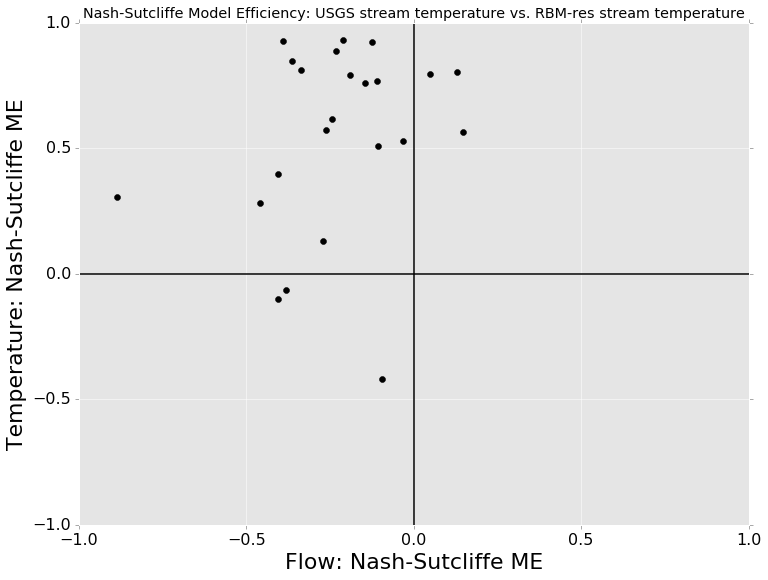

In [36]:
plt.figure(figsize=[12,9])
plt.title('Nash-Sutcliffe Model Efficiency: USGS stream temperature vs. RBM-res stream temperature')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('Flow: Nash-Sutcliffe ME',fontsize=22, color='black')
plt.ylabel('Temperature: Nash-Sutcliffe ME',fontsize=22, color='black')

d1, = plt.plot(data_summary3.nash_sutclf_flow,data_summary3.nash_sutclf_temp,  'ro', color='black',label='measured vs. modeled')    # 
# d2, = plt.plot(data_rbm3.T_stream, color='#5854D5', linestyle='dashdot', linewidth=3, label='RBM-res')    # RBM (yixin) - segment 2 # 

axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([-1,1])
axes.axvline(x=0, color='black',  linewidth=1.5)
axes.axhline(y=0, color='black',   linewidth=1.5)
#axes.set_xlim(['2008-12-1','2009-9-1'])

#leg = plt.legend(handles=[d1,d2], fontsize=15, shadow=True, loc=2)
#leg.get_frame().set_facecolor('#F3F3F3')

#for legobj in leg.legendHandles:
#    legobj.set_linewidth(3.0)


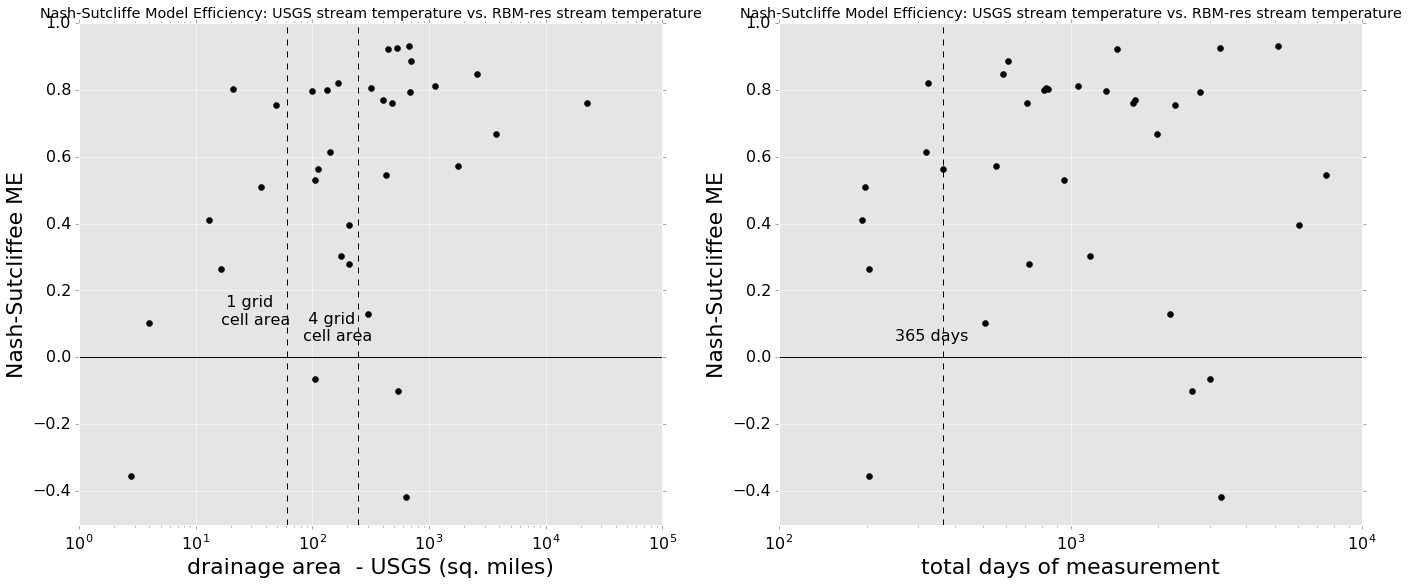

In [39]:
plt.figure(figsize=[23,9])

plt.subplot(121)
plt.title('Nash-Sutcliffe Model Efficiency: USGS stream temperature vs. RBM-res stream temperature')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('drainage area  - USGS (sq. miles)',fontsize=22, color='black')
plt.ylabel('Nash-Sutcliffee ME',fontsize=22, color='black')
plt.text(15,0.1, '  1 grid \n cell area',fontsize=16)
plt.text(75,0.05, '  4 grid \n cell area',fontsize=16)

d1, = plt.semilogx(data_summary3.drainage_area_sq_mi,data_summary3.nash_sutclf_temp,  'ro', color='black',label='measured vs. modeled')    # 
# d2, = plt.plot(data_rbm3.T_stream, color='#5854D5', linestyle='dashdot', linewidth=3, label='RBM-res')    # RBM (yixin) - segment 2 # 

axes = plt.gca()
axes.set_ylim([-0.5,1])
axes.axhline(y=0, color='black')
axes.axvline(x=61, color='black',  linestyle='--')
axes.axvline(x=245, color='black',  linestyle='--')

plt.subplot(122)
plt.title('Nash-Sutcliffe Model Efficiency: USGS stream temperature vs. RBM-res stream temperature')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('total days of measurement',fontsize=22, color='black')
plt.ylabel('Nash-Sutcliffee ME',fontsize=22, color='black')
plt.text(250,0.05, '365 days',fontsize=16)

d1, = plt.semilogx(data_summary3.tot_days,data_summary3.nash_sutclf_temp,  'ro', color='black',label='measured vs. modeled')    # 
# d2, = plt.plot(data_rbm3.T_stream, color='#5854D5', linestyle='dashdot', linewidth=3, label='RBM-res')    # RBM (yixin) - segment 2 # 

axes = plt.gca()
axes.set_ylim([-0.5,1])
axes.axhline(y=0, color='black')
axes.axvline(x=365, color='black',  linestyle='--')


    

In [55]:
data_summary3.head()

,usgs_number,drainage_area_sq_mi,start_yr,end_yr,tot_days,lat,lon,lat_grid,lon_grid,nash_sutclf_temp,...,nash_sutclf_jas_flow,nash_sutclf_jas_f_days,nash_sutclf_ond_flow,nash_sutclf_ond_f_days,rmsd_sutclf_temp,nrmsd_sutclf_temp,ambd_sutclf_temp,rmsd_sutclf_flow,nrmsd_sutclf_flow,ambd_sutclf_flow
0,351706800,206,1999,2016,6047,35.438526,-83.919254,35.4375,-83.9375,0.396,...,-3.767,1012,-0.610,1104,0.086,0.003,3.084,6.530,0.001,-25.534
1,3497300,106,1976,2016,3003,35.664497,-83.710970,35.6875,-83.6875,-0.063,...,-1.093,3312,-0.671,3312,0.172,0.007,4.320,3.534,0.000,-137.040
2,3604000,447,1964,2016,1439,35.496611,-87.833690,35.4375,-87.8125,0.921,...,-0.345,4416,-0.151,4416,0.105,0.004,-1.135,13.383,0.000,-663.849
3,3584600,1805,2014,2016,564,35.013722,-86.994875,35.0625,-86.9375,NaN,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,3582000,827,2012,2016,1313,35.134462,-86.539475,35.1875,-86.5625,NaN,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
data_summary3.columns

Index(['usgs_number', 'drainage_area_sq_mi', 'start_yr', 'end_yr', 'tot_days',
       'lat', 'lon', 'lat_grid', 'lon_grid', 'nash_sutclf_temp',
       'nash_sutclf_temp_days', 'nash_sutclf_jfm_temp',
       'nash_sutclf_jfm_t_days', 'nash_sutclf_amj_temp',
       'nash_sutclf_amj_t_days', 'nash_sutclf_jas_temp',
       'nash_sutclf_jas_t_days', 'nash_sutclf_ond_temp',
       'nash_sutclf_ond_t_days', 'nash_sutclf_flow', 'nash_sutclf_flow_days',
       'nash_sutclf_jfm_flow', 'nash_sutclf_jfm_f_days',
       'nash_sutclf_amj_flow', 'nash_sutclf_amj_f_days',
       'nash_sutclf_jas_flow', 'nash_sutclf_jas_f_days',
       'nash_sutclf_ond_flow', 'nash_sutclf_ond_f_days', 'rmsd_sutclf_temp',
       'nrmsd_sutclf_temp', 'ambd_sutclf_temp', 'rmsd_sutclf_flow',
       'nrmsd_sutclf_flow', 'ambd_sutclf_flow'],
      dtype='object')

/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


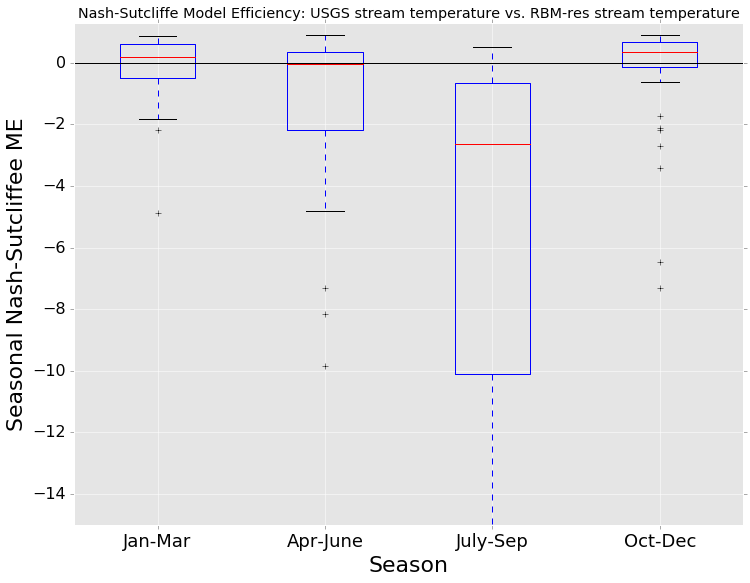

In [89]:
plt.figure(figsize=[12,9])

plt.title('Nash-Sutcliffe Model Efficiency: USGS stream temperature vs. RBM-res stream temperature')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('Season',fontsize=22, color='black')
plt.ylabel('Seasonal Nash-Sutcliffee ME',fontsize=22, color='black')

datax = data_summary3[['nash_sutclf_jfm_temp','nash_sutclf_amj_temp','nash_sutclf_jas_temp','nash_sutclf_ond_temp'] ]
datax.boxplot()
plt.xticks([1, 2, 3, 4], ['Jan-Mar','Apr-June','July-Sep','Oct-Dec'], fontsize=18)
axes = plt.gca()
axes.set_ylim([-15,1.3])
axes.axhline(y=0, color='black')


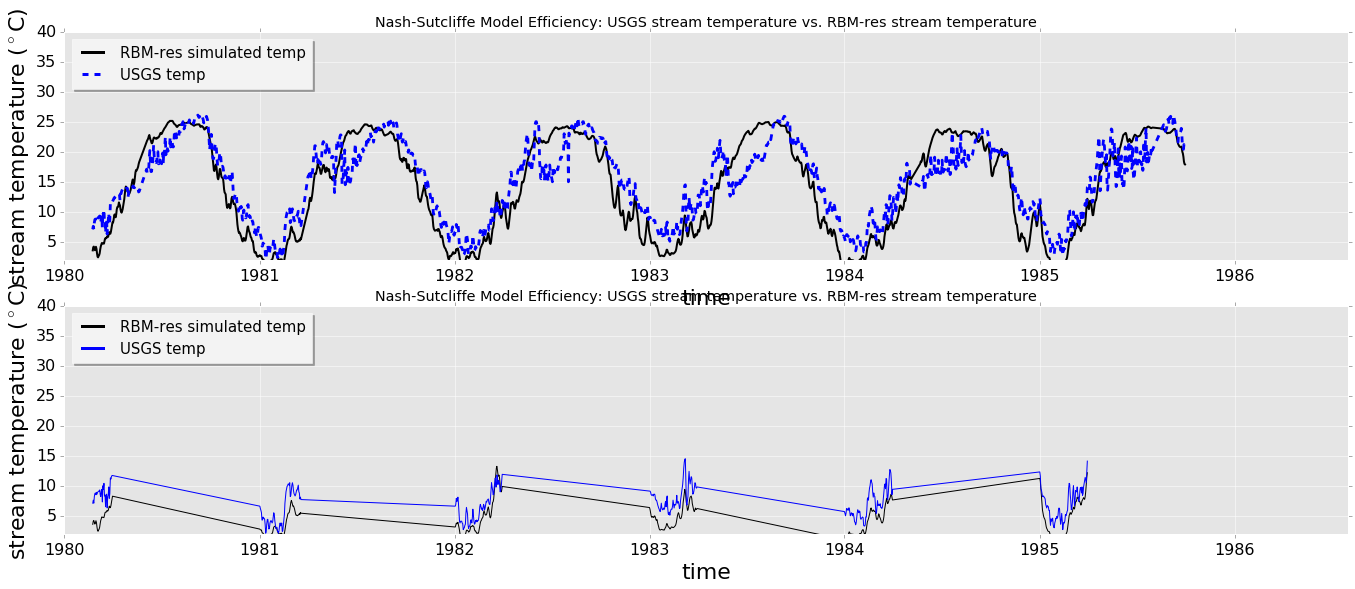

In [160]:
plt.figure(figsize=[23,9])

plt.subplot(211)
plt.title('Nash-Sutcliffe Model Efficiency: USGS stream temperature vs. RBM-res stream temperature')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('time',fontsize=22, color='black')
plt.ylabel('stream temperature ($^\circ$C)',fontsize=22, color='black')

d1, = plt.plot(rbm_df_tot.rbm, color='black',  linewidth=2, label='RBM-res simulated temp')    # RBM (yixin) - segment 2 # 
d2, = plt.plot(rbm_df_tot.obs,  color='blue',linestyle='dashed',linewidth=2.8,label='USGS temp')    # 

axes = plt.gca()
axes.set_ylim([2,40])
axes.set_xlim(['1980-1-1','1986-8-1'])

leg = plt.legend(handles=[d1,d2], fontsize=15, shadow=True, loc=2)
leg.get_frame().set_facecolor('#F3F3F3')

for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.subplot(212)
plt.title('Nash-Sutcliffe Model Efficiency: USGS stream temperature vs. RBM-res stream temperature')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('time',fontsize=22, color='black')
plt.ylabel('stream temperature ($^\circ$C)',fontsize=22, color='black')

d1, = plt.plot(rbm_df.rbm, 'r', color='black', label='RBM-res simulated temp')    # RBM (yixin) - segment 2 # 
d2, = plt.plot(rbm_df.obs, 'r', color='blue', label='USGS temp')    # 

axes = plt.gca()
axes.set_ylim([2,40])
axes.set_xlim(['1980-1-1','1986-8-1'])

leg = plt.legend(handles=[d1,d2], fontsize=15, shadow=True, loc=2)
leg.get_frame().set_facecolor('#F3F3F3')

for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)


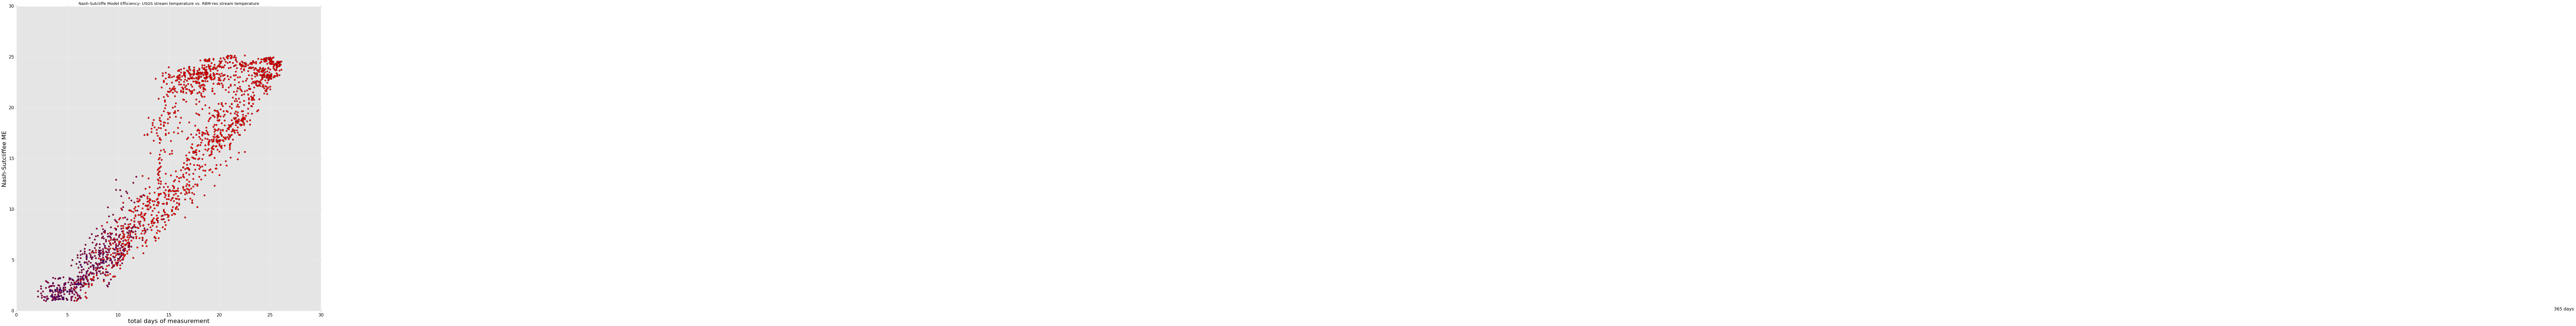

In [172]:
plt.figure(figsize=[20,20])

plt.title('Nash-Sutcliffe Model Efficiency: USGS stream temperature vs. RBM-res stream temperature')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('total days of measurement',fontsize=22, color='black')
plt.ylabel('Nash-Sutcliffee ME',fontsize=22, color='black')
plt.text(250,0.05, '365 days',fontsize=16)

d1, = plt.plot(rbm_df_tot.obs,rbm_df_tot.rbm,  'ro', marker='o',color='red',alpha=1,label='Total: measured vs. modeled')    # 
d2, = plt.plot(rbm_df.obs,rbm_df.rbm,  'ro', color='blue',alpha=0.4,markersize=5,label='Jan/Feb/Mar: measured vs. modeled')    # 

#axes = plt.gca()
#axes.set_ylim([-0.5,1])
#axes.axhline(y=0, color='black')
#axes.axvline(x=365, color='black',  linestyle='--')




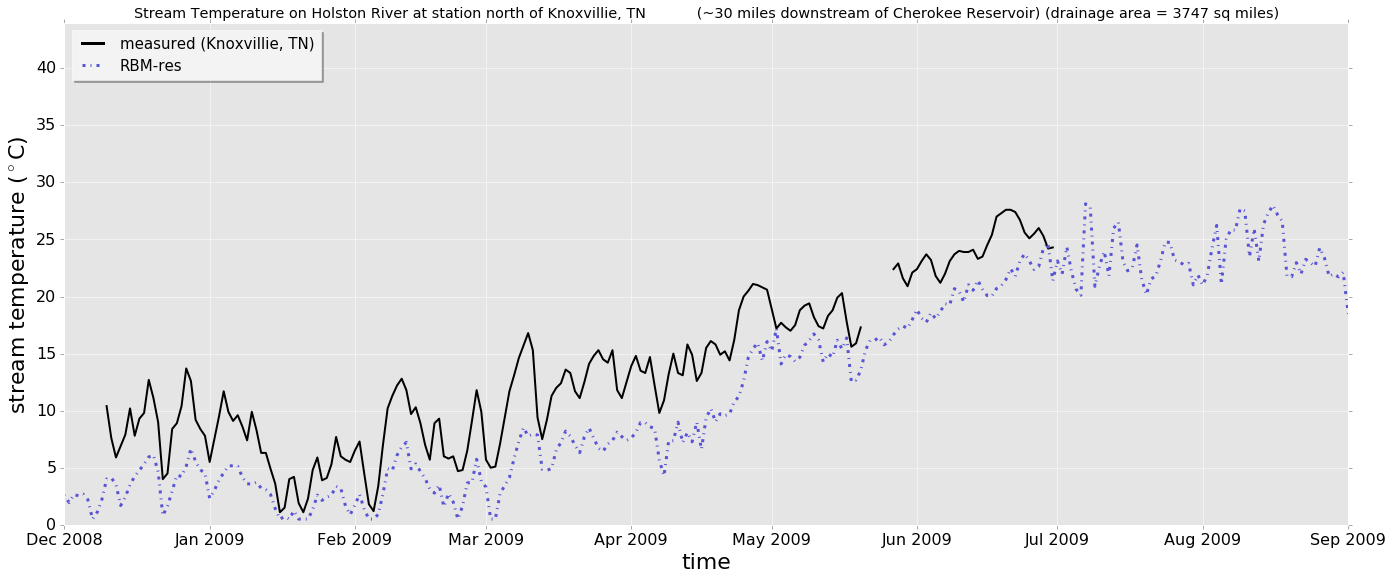

In [84]:
plt.figure(figsize=[23,9])
plt.title('Stream Temperature on Holston River at station north of Knoxvillie, TN \
          (~30 miles downstream of Cherokee Reservoir) (drainage area = 3747 sq miles)')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('time',fontsize=22, color='black')
plt.ylabel('stream temperature ($^\circ$C)',fontsize=22, color='black')

d1, = plt.plot(data_usgs2.t_mean, color='black', linewidth=2,label='measured (Knoxvillie, TN)')    # 
d2, = plt.plot(data_rbm3.T_stream, color='#5854D5', linestyle='dashdot', linewidth=3, label='RBM-res')    # RBM (yixin) - segment 2 # 

axes = plt.gca()
axes.set_ylim([0,44])
axes.set_xlim(['2008-12-1','2009-9-1'])

leg = plt.legend(handles=[d1,d2], fontsize=15, shadow=True, loc=2)
leg.get_frame().set_facecolor('#F3F3F3')

for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)


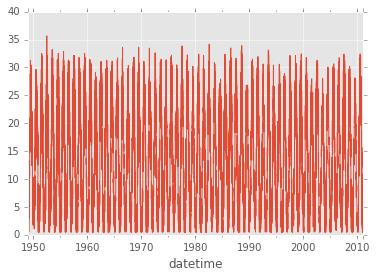

In [78]:
data_rbm3.T_stream.plot()

In [30]:
data_usgs = pd.read_table(filePath, skiprows=line_count + 1, sep='\t', names = headers) # index_col='datetime'
indices = [i for i, s in enumerate(headers) if '00010_00003' in s] # mean temperature
indices2 = [i for i, s in enumerate(headers) if 'datetime' in s]
indices = sorted(indices + indices2)
data_usgs2 = data_usgs[indices]
data_usgs2.columns = ['datetime','t_mean','t_cd']
datetime2 = pd.to_datetime(data_usgs2.datetime)
data_usgs2 = data_usgs2.set_index(datetime2)

/raid3/rniemeyr/RBM/data/USGS/Tennessee_Basin/03598177.txt


In [82]:
data_usgs2.tail()

,datetime,t_mean,t_cd
datetime,,,
2009-06-26,2009-06-26,25.5,A
2009-06-27,2009-06-27,26.0,A
2009-06-28,2009-06-28,25.3,A
2009-06-29,2009-06-29,24.2,A
2009-06-30,2009-06-30,24.3,A


In [177]:
filePath = '/raid3/rniemeyr/RBM/data/USGS/Tennessee_Basin/03598177.txt'
data = pd.read_table(filePath, skiprows=28, sep='\t', 
    names = headers,
    parse_dates=['datetime'], 
    date_parser=dateparse) # index_col='datetime'
indices = [i for i, s in enumerate(headers) if '00010_00003' in s] # mean temperature
indices2 = [i for i, s in enumerate(headers) if 'datetime' in s]
indices = sorted(indices + indices2)
data2 = data[indices]
data2.columns = ['datetime','t_mean','t_cd']
datetime2 = pd.to_datetime(data2.datetime)
data2 = data2.set_index(datetime2)

#headers2 = [ headers[i] for i in indices ]
#data = data[-indices]  # drop unnecessary rows
#data = data.drop(data.index[indices])
#data.index = pd.to_datetime(data.pop('datetime'))  # makes 'datetime' index and removes it

In [178]:
data2.head()

,datetime,t_mean,t_cd
datetime,,,
2008-12-01,2008-12-01,NaN,NaN
2008-12-02,2008-12-02,NaN,NaN
2008-12-03,2008-12-03,NaN,NaN
2008-12-04,2008-12-04,NaN,NaN
2008-12-05,2008-12-05,NaN,NaN


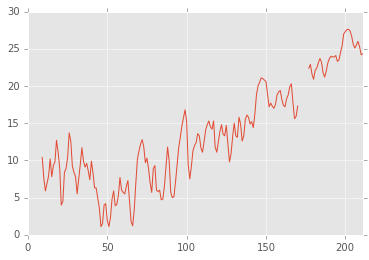

In [176]:
data2.t_mean.plot()